# **ML4SCI Google Summer of Code 2025**

## **Event Classification With Masked Transformer Autoencoders**

In [1]:
# --- Default libraries ---
import os
import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Iterable

# --- Working directory ---
PROJECT_DIR = Path().resolve()
PROJECT_ROOT_NAME = 'Hybrid_Transformer_Thanh_Nguyen'

while PROJECT_DIR.name != PROJECT_ROOT_NAME and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

if Path().resolve() != PROJECT_DIR:
    os.chdir(PROJECT_DIR)

DATA_DIR = PROJECT_DIR / 'data'
LOG_DIR = PROJECT_DIR / 'logs'

# --- Data preprocessing & visualization ---
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def parse_experiment_filename(file_path: Path) -> Tuple[str, str, int]:
    pattern = re.compile(r"^(pretrained|scratch)_(ParT|LorentzParT)_(\d{2})\.out$", re.IGNORECASE)
    match = pattern.match(file_path.name)
    if not match:
        raise ValueError(f"Unexpected filename format: {file_path.name}")

    training_mode = match.group(1).lower()
    model_type = match.group(2)
    seed_int = int(match.group(3))

    return training_mode, model_type, seed_int


_NUMBER = r"[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?"
_LOSS_PATTERNS = [
    re.compile(rf"\btrain[_\s\-]*loss\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
    re.compile(rf"\btraining[_\s\-]*loss\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
]
_ACC_PATTERNS = [
    re.compile(rf"\btrain[_\s\-]*metric\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
    re.compile(rf"\btraining[_\s\-]*metric\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
]


def _find_number(line: str, patterns: Iterable[re.Pattern]) -> Optional[float]:
    for pattern in patterns:
        match = pattern.search(line)
        if match:
            try:
                return float(match.group(1))
            except ValueError:
                continue
            
    return None


def parse_metrics_from_log(file_path: Path) -> Tuple[List[float], List[float]]:
    train_loss_list = []
    train_acc_list = []
    with file_path.open('r', encoding='utf-8', errors='ignore') as file_handle:
        for line in file_handle:
            loss_value = _find_number(line, _LOSS_PATTERNS)
            if loss_value is not None:
                train_loss_list.append(loss_value)

            acc_value = _find_number(line, _ACC_PATTERNS)
            if acc_value is not None:
                train_acc_list.append(acc_value)

    # Align lengths if the two signals are logged at different frequencies
    min_length = min(len(train_loss_list), len(train_acc_list)) if train_loss_list and train_acc_list else 0
    if min_length > 0:
        train_loss_list = train_loss_list[:min_length]
        train_acc_list = train_acc_list[:min_length]

    return train_loss_list, train_acc_list


def load_runs(logs_dir: str = './logs') -> Dict[Tuple[str, str], Dict[int, Dict[str, List[float]]]]:
    base = Path(logs_dir)
    if not base.exists():
        raise FileNotFoundError(f"Logs directory not found: {logs_dir}")

    grouped = {}

    for file_path in base.glob('*.out'):
        try:
            training_mode, model_type, seed_int = parse_experiment_filename(file_path)
        except ValueError:
            continue

        train_loss_list, train_acc_list = parse_metrics_from_log(file_path)
        if not train_loss_list and not train_acc_list:
            continue

        key = (model_type, training_mode)
        if key not in grouped:
            grouped[key] = {}

        grouped[key][seed_int] = {
            'loss': train_loss_list,
            'metric': train_acc_list,
        }

    return grouped


def _stack_trimmed(series_list: List[List[float]]) -> np.ndarray:
    if not series_list:
        return np.zeros((0, 0), dtype=float)

    min_length = min(len(series) for series in series_list if series)
    if min_length == 0:
        return np.zeros((0, 0), dtype=float)

    trimmed_series = [np.asarray(series[:min_length], dtype=float) for series in series_list]

    return np.stack(trimmed_series, axis=0)


def plot_training_from_logs(
    log_dir: str = './logs',
    save_fig: Optional[str] = None,
    show_seed_lines: bool = True,
    seed: Optional[int] = None,
    max_steps: int = 50,
) -> None:
    grouped = load_runs(log_dir)
    if not grouped:
        raise RuntimeError("No parsable logs found. Check filenames and regex patterns.")

    color_map = {
        'ParT': 'tab:blue',
        'LorentzParT': 'tab:orange',
    }
    linestyle_map = {
        'scratch': '--',
        'pretrained': '-',
    }

    plt.figure(figsize=(12, 5))
    axis_loss = plt.subplot(1, 2, 1)
    axis_accuracy = plt.subplot(1, 2, 2)

    legend_handles_loss = []
    legend_labels_loss = []
    legend_handles_accuracy = []
    legend_labels_accuracy = []

    any_series_plotted = False

    for (model_type, training_mode), seeds_dict in sorted(grouped.items()):
        if seed is not None:
            if seed in seeds_dict:
                seeds_dict = {seed: seeds_dict[seed]}
            else:
                continue

        model_color = color_map.get(model_type, None)
        line_style = linestyle_map.get(training_mode, '-')

        loss_series_list = []
        accuracy_series_list = []

        if show_seed_lines:
            for _, values in sorted(seeds_dict.items()):
                loss_values = values['loss'][:max_steps]
                accuracy_values = values['metric'][:max_steps]

                if loss_values:
                    training_step_indices = np.arange(1, len(loss_values) + 1)
                    if model_color is None:
                        axis_loss.plot(
                            training_step_indices,
                            loss_values,
                            linestyle=line_style,
                            alpha=0.25,
                            linewidth=1.0,
                        )
                    else:
                        axis_loss.plot(
                            training_step_indices,
                            loss_values,
                            color=model_color,
                            linestyle=line_style,
                            alpha=0.25,
                            linewidth=1.0,
                        )

                    any_series_plotted = True
                    loss_series_list.append(loss_values)

                if accuracy_values:
                    training_step_indices = np.arange(1, len(accuracy_values) + 1)
                    if model_color is None:
                        axis_accuracy.plot(
                            training_step_indices,
                            accuracy_values,
                            linestyle=line_style,
                            alpha=0.25,
                            linewidth=1.0,
                        )
                    else:
                        axis_accuracy.plot(
                            training_step_indices,
                            accuracy_values,
                            color=model_color,
                            linestyle=line_style,
                            alpha=0.25,
                            linewidth=1.0,
                        )

                    any_series_plotted = True
                    accuracy_series_list.append(accuracy_values)

        mean_loss_handle = None
        if seeds_dict:
            if not loss_series_list:
                loss_series_list = [values['loss'][:max_steps] for values in seeds_dict.values() if values['loss']]

            if loss_series_list:
                loss_stack = _stack_trimmed(loss_series_list)
                if loss_stack.size > 0:
                    mean_loss = loss_stack.mean(axis=0)
                    training_step_indices = np.arange(1, mean_loss.shape[0] + 1)
                    if model_color is None:
                        mean_loss_handle = axis_loss.plot(
                            training_step_indices,
                            mean_loss,
                            linestyle=line_style,
                            linewidth=2.25,
                        )[0]
                    else:
                        mean_loss_handle = axis_loss.plot(
                            training_step_indices,
                            mean_loss,
                            color=model_color,
                            linestyle=line_style,
                            linewidth=2.25,
                        )[0]

                    legend_handles_loss.append(mean_loss_handle)
                    legend_labels_loss.append(f"{model_type} {training_mode} (mean)")
                    any_series_plotted = True

        mean_accuracy_handle = None
        if seeds_dict:
            if not accuracy_series_list:
                accuracy_series_list = [values['metric'][:max_steps] for values in seeds_dict.values() if values['metric']]

            if accuracy_series_list:
                accuracy_stack = _stack_trimmed(accuracy_series_list)
                if accuracy_stack.size > 0:
                    mean_accuracy = accuracy_stack.mean(axis=0)
                    training_step_indices = np.arange(1, mean_accuracy.shape[0] + 1)
                    if model_color is None:
                        mean_accuracy_handle = axis_accuracy.plot(
                            training_step_indices,
                            mean_accuracy,
                            linestyle=line_style,
                            linewidth=2.25,
                        )[0]
                    else:
                        mean_accuracy_handle = axis_accuracy.plot(
                            training_step_indices,
                            mean_accuracy,
                            color=model_color,
                            linestyle=line_style,
                            linewidth=2.25,
                        )[0]

                    legend_handles_accuracy.append(mean_accuracy_handle)
                    legend_labels_accuracy.append(f"{model_type} {training_mode} (mean)")
                    any_series_plotted = True

    if not any_series_plotted:
        if seed is not None:
            raise RuntimeError(f"No parsable logs found for seed {seed}.")

        raise RuntimeError("No parsable logs produced any series to plot.")

    axis_loss.set_title("Training Loss")
    axis_loss.set_xlabel("Training step")
    axis_loss.set_ylabel("Loss")
    axis_loss.grid(True, alpha=0.3)
    axis_loss.set_xlim(1, max_steps)
    if legend_handles_loss:
        axis_loss.legend(legend_handles_loss, legend_labels_loss, loc='upper right', fontsize=9)

    axis_accuracy.set_title("Training Accuracy")
    axis_accuracy.set_xlabel("Training step")
    axis_accuracy.set_ylabel("Accuracy")
    axis_accuracy.grid(True, alpha=0.3)
    axis_accuracy.set_xlim(1, max_steps)
    if legend_handles_accuracy:
        axis_accuracy.legend(legend_handles_accuracy, legend_labels_accuracy, loc='lower right', fontsize=9)

    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300, bbox_inches='tight')
    else:
        plt.show()

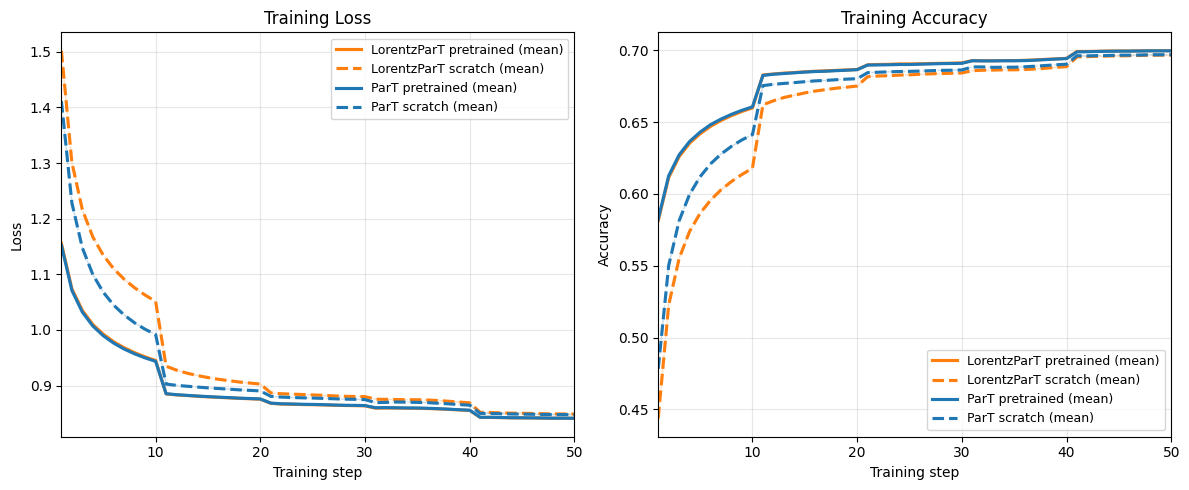

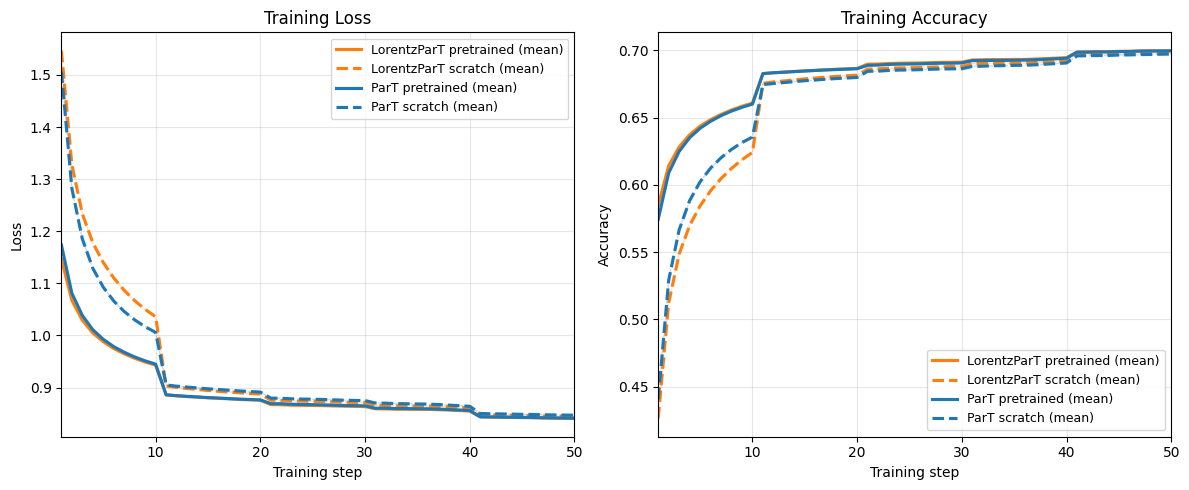

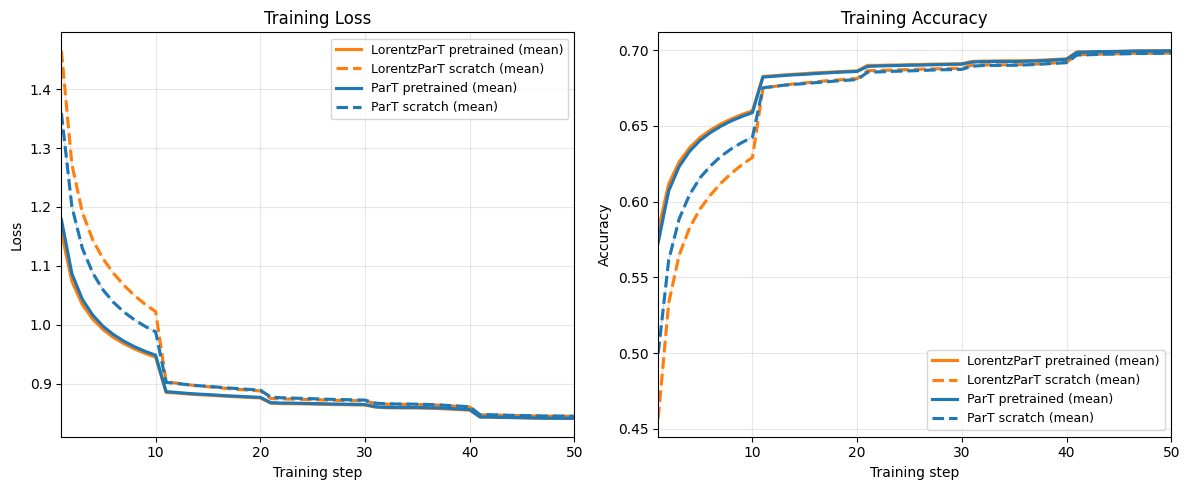

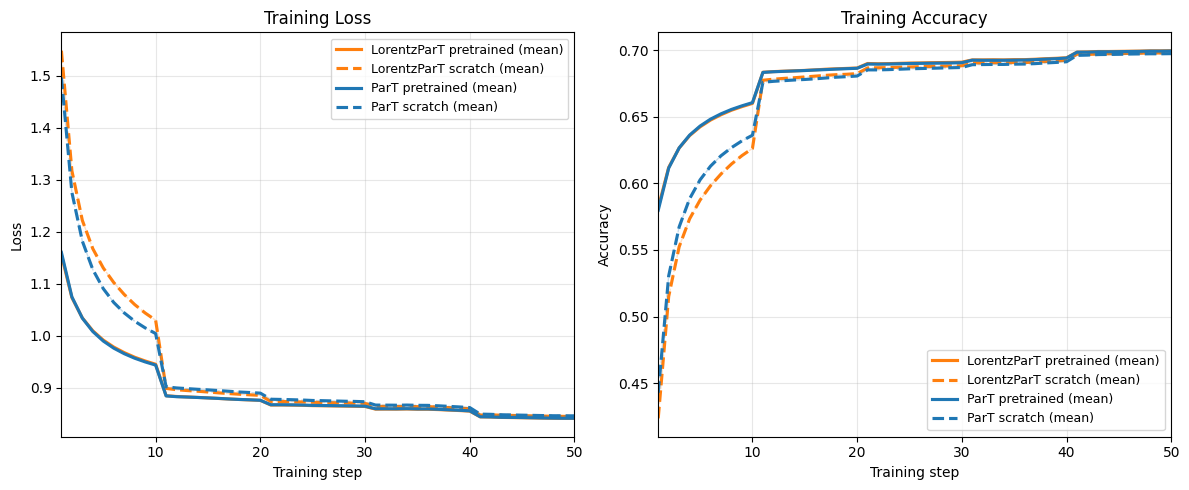

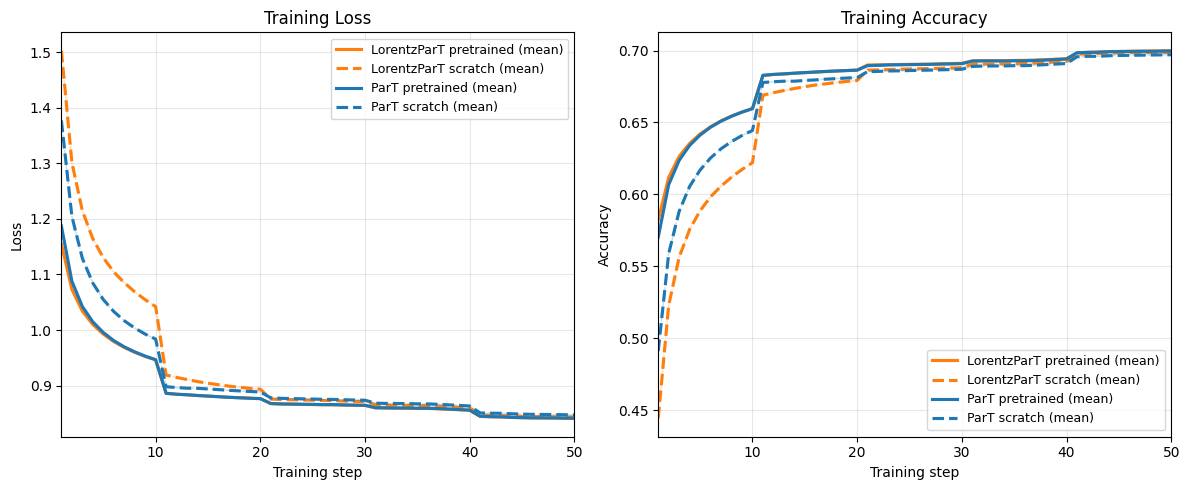

In [3]:
for seed in range(42, 47):
    plot_training_from_logs(str(LOG_DIR), save_fig=None, show_seed_lines=True, seed=seed)

In [4]:
_TEST_LOSS_PATTERNS = [
    re.compile(rf"\btest[_\s\-]*loss\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
]
_TEST_METRIC_PATTERNS = [
    re.compile(rf"\btest[_\s\-]*(?:metric|acc|accuracy)\b\s*[:=]\s*({_NUMBER})", re.IGNORECASE),
]


def parse_eval_filename(file_path: Path) -> Tuple[str, str, int]:
    pattern = re.compile(r"^eval_(pretrained|scratch)_(ParT|LorentzParT)_(\d{2})\.out$", re.IGNORECASE)
    match = pattern.match(file_path.name)
    if not match:
        raise ValueError(f"Unexpected filename format: {file_path.name}")
    
    training_mode = match.group(1).lower()
    model_type = match.group(2)
    seed_int = int(match.group(3))

    return training_mode, model_type, seed_int


def _find_number(line: str, patterns: Iterable[re.Pattern]) -> Optional[float]:
    for pattern in patterns:
        match = pattern.search(line)
        if match:
            try:
                return float(match.group(1))
            except ValueError:
                continue

    return None


def parse_eval_from_file(file_path: Path) -> Tuple[Optional[float], Optional[float]]:
    test_loss_value = None
    test_metric_value = None
    with file_path.open('r', encoding='utf-8', errors='ignore') as file_handle:
        for line in file_handle:
            if test_loss_value is None:
                maybe_loss = _find_number(line, _TEST_LOSS_PATTERNS)
                if maybe_loss is not None:
                    test_loss_value = maybe_loss

            if test_metric_value is None:
                maybe_metric = _find_number(line, _TEST_METRIC_PATTERNS)
                if maybe_metric is not None:
                    test_metric_value = maybe_metric

            if test_loss_value is not None and test_metric_value is not None:
                break

    return test_loss_value, test_metric_value


def collect_eval_results(logs_dir: str = './logs') -> Dict[Tuple[str, str], Dict[str, List[float]]]:
    base_path = Path(logs_dir)
    if not base_path.exists():
        raise FileNotFoundError(f"Logs directory not found: {logs_dir}")

    grouped: Dict[Tuple[str, str], Dict[str, List[float]]] = {}
    for file_path in base_path.glob('eval_*.out'):
        try:
            training_mode, model_type, _ = parse_eval_filename(file_path)
        except ValueError:
            continue

        test_loss_value, test_metric_value = parse_eval_from_file(file_path)
        if test_loss_value is None and test_metric_value is None:
            continue

        key = (model_type, training_mode)
        if key not in grouped:
            grouped[key] = {'loss': [], 'metric': []}
        if test_loss_value is not None:
            grouped[key]['loss'].append(test_loss_value)
        if test_metric_value is not None:
            grouped[key]['metric'].append(test_metric_value)

    if not grouped:
        raise RuntimeError("No parsable eval files found. Expected files like 'eval_pretrained_ParT_42.out'.")

    return grouped


def _mean_min_max(values: List[float]) -> Tuple[float, float, float]:
    array = np.asarray(values, dtype=float)

    return float(array.mean()), float(array.min()), float(array.max())


def plot_eval_min_max_intervals(
    log_dir: str = './logs',
    save_fig: Optional[str] = None,
    annotate_means: bool = True,
) -> None:
    grouped = collect_eval_results(log_dir)

    model_order = ['ParT', 'LorentzParT']
    mode_order = ['pretrained', 'scratch']

    color_map = {
        'ParT': 'tab:blue',
        'LorentzParT': 'tab:orange'
    }
    linestyle_map = {
        'pretrained': '-',
        'scratch': ':',
    }

    # Prepare data arrays: for each subplot we will plot at x positions 0 and 1
    model_positions = {model: index for index, model in enumerate(model_order)}
    mode_offsets = {
        'pretrained': -0.12,
        'scratch': +0.12,
    }

    # Create figure
    plt.figure(figsize=(10, 5))
    axis_loss = plt.subplot(1, 2, 1)
    axis_metric = plt.subplot(1, 2, 2)

    legend_handles = []
    legend_labels = []
    for model_type in model_order:
        for training_mode in mode_order:
            key = (model_type, training_mode)
            if key not in grouped:
                continue

            # Compute stats
            loss_values = grouped[key]['loss']
            metric_values = grouped[key]['metric']

            model_x = model_positions[model_type] + mode_offsets[training_mode]
            model_color = color_map.get(model_type, None)
            if training_mode == 'pretrained' and isinstance(model_color, str) and model_color.startswith('tab:'):
                model_color = model_color.split(':', 1)[1]

            line_style = linestyle_map[training_mode]

            # Plot loss if available
            if loss_values:
                mean_value, min_value, max_value = _mean_min_max(loss_values)
                lower_err = mean_value - min_value
                upper_err = max_value - mean_value
                if model_color is None:
                    handle_loss = axis_loss.errorbar(
                        x=[model_x],
                        y=[mean_value],
                        yerr=[[lower_err], [upper_err]],
                        fmt='o',
                        linestyle=line_style,
                        capsize=4,
                        linewidth=1.75,
                    )
                else:
                    handle_loss = axis_loss.errorbar(
                        x=[model_x],
                        y=[mean_value],
                        yerr=[[lower_err], [upper_err]],
                        fmt='o',
                        linestyle=line_style,
                        color=model_color,
                        capsize=4,
                        linewidth=1.75,
                    )

                if annotate_means:
                    axis_loss.text(model_x, mean_value, f'{mean_value:.4f}', ha='center', va='bottom', fontsize=8)

                # Save one handle per (model, mode) to use in both legends
                if not any(lbl == f"{model_type} {training_mode}" for lbl in legend_labels):
                    legend_handles.append(handle_loss.lines[0])
                    legend_labels.append(f"{model_type} {training_mode}")

            # Plot accuracy if available
            if metric_values:
                mean_value, min_value, max_value = _mean_min_max(metric_values)
                lower_err = mean_value - min_value
                upper_err = max_value - mean_value
                if model_color is None:
                    handle_metric = axis_metric.errorbar(
                        x=[model_x],
                        y=[mean_value],
                        yerr=[[lower_err], [upper_err]],
                        fmt="o",
                        linestyle=line_style,
                        capsize=4,
                        linewidth=1.75,
                    )
                else:
                    handle_metric = axis_metric.errorbar(
                        x=[model_x],
                        y=[mean_value],
                        yerr=[[lower_err], [upper_err]],
                        fmt="o",
                        linestyle=line_style,
                        color=model_color,
                        capsize=4,
                        linewidth=1.75,
                    )

                if annotate_means:
                    axis_metric.text(model_x, mean_value, f'{mean_value:.4f}', ha='center', va='bottom', fontsize=8)

    # Ax cosmetics
    axis_loss.set_title("Test Loss (min-max across seeds)")
    axis_loss.set_ylabel("Loss")
    axis_loss.set_xticks([model_positions[m] for m in model_order], labels=model_order)
    axis_loss.grid(True, alpha=0.3)

    axis_metric.set_title("Test Accuracy (min-max across seeds)")
    axis_metric.set_ylabel("Accuracy")
    axis_metric.set_xticks([model_positions[m] for m in model_order], labels=model_order)
    axis_metric.grid(True, alpha=0.3)

    if legend_handles:
        axis_loss.legend(legend_handles, legend_labels, loc='best', fontsize=9)
        axis_metric.legend(legend_handles, legend_labels, loc='best', fontsize=9)

    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300, bbox_inches='tight')
    else:
        plt.show()

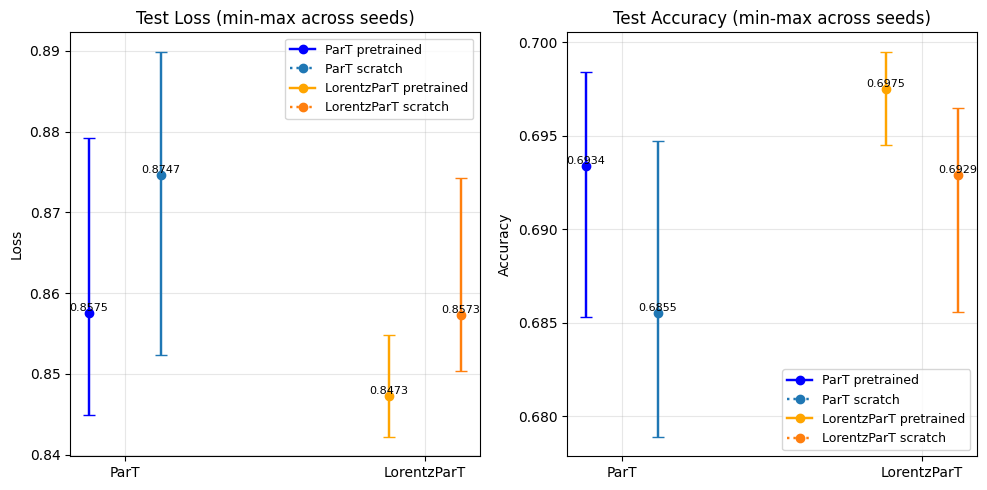

In [5]:
plot_eval_min_max_intervals(log_dir=str(LOG_DIR), save_fig=None, annotate_means=True)